In [ ]:
# !pip install bnunicodenormalizer
# !pip install jiwer
# !pip install nltk
# !pip install librosa
# !pip install pandas
# import nltk
# nltk.download('punkt')

In [1]:
import torch
import torchaudio
import string
import nltk
import math
import itertools
import librosa
import librosa.display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from scipy import signal
from torch import nn, optim
from joblib import Parallel, delayed
from jiwer import wer, cer
from torch.utils.data import Dataset, DataLoader
from torchaudio.models.decoder import ctc_decoder
from collections import Counter
from nltk.tokenize import word_tokenize
from bnunicodenormalizer import Normalizer 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
# Load and examine data
train_df = pd.read_csv('./input/bengaliai-speech/train.csv')
train_df.head(5)

,id,sentence,split
0,000005f3362c,ও বলেছে আপনার ঠিকানা!,train
1,00001dddd002,কোন মহান রাষ্ট্রের নাগরিক হতে চাও?,train
2,00001e0bc131,"আমি তোমার কষ্টটা বুঝছি, কিন্তু এটা সঠিক পথ না।",train
3,000024b3d810,নাচ শেষ হওয়ার পর সকলে শরীর ধুয়ে একসঙ্গে ভোজন...,train
4,000028220ab3,"হুমম, ওহ হেই, দেখো।",train


In [3]:
#### Data selection for prototyping (delete/comment out for full training)
NUM_EXAMPLES = 50000
group = 1
if group < 5:
    train_df = train_df.iloc[NUM_EXAMPLES*(group-1):NUM_EXAMPLES*group, :]
else:
    train_df = train_df.iloc[NUM_EXAMPLES*(group-1):, :]
##############################################################

## Preprocessing text

In [4]:
bnorm = Normalizer()
def process_text(sentence):    
    # Remove special characters
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))

    # Normalize sentences with bnunicodenormalizer
    tokens = word_tokenize(sentence)
    norm_tokens = [bnorm(token)['normalized'] for token in tokens]
    norm_sentence = " ".join([word for word in norm_tokens if word is not None])
    
    # Get unique characters
    unique_sentence_chars = list(set([*norm_sentence]))
    
    return norm_sentence, unique_sentence_chars

# Get all unique characters in data set and normalize sentences
norm_sentences, unique_chars_per_sentence = zip(*Parallel(n_jobs=-1)(delayed(process_text)
                                                                     (train_df.at[index, 'sentence']) 
                                                                     for index, row in tqdm(train_df.iterrows())))

all_chars = list(itertools.chain.from_iterable(unique_chars_per_sentence))
unique_chars = list(set(all_chars))
unique_chars.append('_') # add label space to character labels
print(str(len(unique_chars)) + " unique characters")

# Get maximum sentence length
max_sentence_length = max([len(sentence.split(' ')) for sentence in norm_sentences])
print('Maximum sentence length = ' + str(max_sentence_length) + ' words')

# Get vocabulary size
all_words = list(itertools.chain(*[sentence.split(' ') for sentence in norm_sentences]))
unique_words = list(set(all_words))
vocabulary_size = len(Counter(all_words).keys())
print('The vocabulary includes ' + str(vocabulary_size) + ' words')

# Save normalized dataset
train_df['sentence'] = norm_sentences
train_df.to_csv('./working/norm_train.csv', index=False)

# # Save list of unique characters
# with open('./working/unique_chars.txt', 'w', encoding="utf-8") as f:
#     for char in unique_chars:
#         f.write("%s\n" % char)
        
# Clean up
del all_chars
del all_words
del unique_words

50000it [00:17, 2797.48it/s]


67 unique characters
Maximum sentence length = 21 words
The vocabulary includes 55710 words


## Define torch Dataset for data loading

In [5]:
import os
from torchvision.io import read_image
SAMPLE_RATE=16000

# Frequency and time masking only for training
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_mels=128, power=2.0),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=0),
    nn.Unflatten(dim=0, unflattened_size=(1, -1, 128)), # TimeMasking expects a batch dimension
    torchaudio.transforms.TimeMasking(time_mask_param=0)
)
# Just get spectrogram for validation
valid_audio_transforms = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_mels=128)

class BengaliAIDataset(Dataset):
    def __init__(self, utterance_file, audio_dir, data_type='training', 
                 transform=None, target_transform=None):
        self.audio_dir = audio_dir
        if data_type in ['training', 'validation']:
            self.sentence_labels = pd.read_csv(utterance_file)
        else:
            self.sentence_labels = os.listdir(self.audio_dir)
        self.transform = transform
        self.target_transform = target_transform
        self.data_type = data_type

    def __len__(self):
        return len(self.sentence_labels)

    def __getitem__(self, idx):
        if self.data_type in ['training', 'validation']:
            audio_path = os.path.join(self.audio_dir,
                                      self.sentence_labels.iloc[idx, 0] + '.mp3')
            waveform, sr = librosa.load(audio_path, sr=32000)
            label = self.sentence_labels.iloc[idx, 1]
            if self.transform:
                waveform = self.transform(waveform)
            if self.target_transform:
                label = self.target_transform(label)
            return waveform, label
        else:
            file_list = os.listdir(self.audio_dir)
            audio_path = os.path.join(self.audio_dir,
                                      file_list[idx])
            waveform, sr = librosa.load(audio_path, sr=32000)
            if self.transform:
                waveform = self.transform(waveform)
            return waveform

C:\Users\Dawson\anaconda3\envs\pytorch\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


## Process data in training

In [6]:
# Define data processing before each batch
def data_processing(data, data_type='training'):
    labeled_sentences = []
    spectrograms = []
    input_lengths = []
    label_lengths = []
    if data_type in ['training', 'validation']:
        for (waveform, sentence) in data:
            # Resample waveform and convert to Tensor
            waveform = librosa.resample(waveform, orig_sr=32000, target_sr=16000)
            waveform = torch.Tensor(waveform)

            # Audio transform during training and inference
            if data_type == 'training':
                spec = train_audio_transforms(waveform).squeeze().transpose(0, 1)
            else:
                spec = valid_audio_transforms(waveform).squeeze().transpose(0, 1)
            spec = librosa.power_to_db(spec, ref=np.max)
            spectrograms.append(torch.Tensor(spec))

            # Map characters to integer labels and get input lengths
            sentence_labels = []
            for char in sentence:
                sentence_labels.append(unique_chars.index(char))
            label = torch.Tensor(sentence_labels)
            labeled_sentences.append(label)

            input_lengths.append(spec.shape[0]//2)
            label_lengths.append(len(sentence))

        # Pad sequences
        spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True, padding_value=-80).unsqueeze(1).transpose(2, 3)
        labels = nn.utils.rnn.pad_sequence(labeled_sentences, batch_first=True, padding_value=len(unique_chars)+1)
    
        return spectrograms, labels, input_lengths, label_lengths
    
    else: # For evaluation
        for waveform in data:
            # Resample waveform and convert to Tensor
            waveform = librosa.resample(waveform, orig_sr=32000, target_sr=16000)
            waveform = torch.Tensor(waveform)

            spec = valid_audio_transforms(waveform).squeeze().transpose(0, 1)
            spec = librosa.power_to_db(spec, ref=np.max)
            spectrograms.append(torch.Tensor(spec))

            input_lengths.append(spec.shape[0])

        # Pad sequences
        spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True, padding_value=-80).unsqueeze(1).transpose(2, 3)

        return spectrograms, input_lengths

## Define the model

In [7]:
# Model based on post at "https://www.assemblyai.com/blog/end-to-end-speech-recognition-pytorch/""
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 
    
class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)
    
class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x
    
class SpeechRecognitionModel(nn.Module):
    """Speech Recognition Model Inspired by DeepSpeech 2"""

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

## Basic greedy decoder (beam-search later)

In [8]:
f = open("./working/unique_chars.txt", "r", encoding="utf-8")
unique_chars = [label.replace('\n', '') for label in f.readlines()]

def GreedyDecoder(output, blank_label=len(unique_chars)-1, collapse_repeated=True):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(unique_chars[index])
        decodes.append(decode)
    return decodes

def norm_decoded_results(decoded_results):
    bnorm = Normalizer()
    evaluated_sentences = []
    i=0
    for utterance in decoded_results:
        try:
            # Normalize sentences with bnunicodenormalizer
            utterance = "".join(utterance)
            norm_tokens = [bnorm(word)['normalized'] for word in utterance.split()]
            norm_sentence = "".join([word for word in norm_tokens if word is not None])
        except:
            norm_sentence = ','

        # Combine decoded results into sentence
        evaluated_sentences.append(norm_sentence)
    
    return evaluated_sentences

## Create KenLM lexicon file

In [9]:
ken_vocab = open("./working/bn.sp.vocab", "r", encoding='utf-8')
lines = ken_vocab.readlines()

line_count = 0
with open('./working/lexicon.txt', 'w', encoding='utf-8') as file:
    for line in tqdm(lines):
        # Formatting from KenLM vocab file
        line = line.split('\t')
        if '▁' in line[0]:
            line = line[0].replace('▁', '')
        else:
            line = line[0]

        char_list = [char for char in line]
        # Do not process lines if they contain invalid characters
        if any(map(lambda char: char not in unique_chars, char_list)):
            continue
        elif line == '':
            continue
        else:
            processed_string = line + " " + " ".join(line) + " _"
            file.write(processed_string + '\n')

            line_count += 1
print(str(line_count) + ' lines saved out of ' + str(len(lines)))
file.close()

100%|████████████████████████████████████████████████████████████████████████| 40000/40000 [00:00<00:00, 195645.36it/s]

29605 lines saved out of 40000


## Beam search decoder with KenLM

In [10]:
def BeamSearchDecoder(BEAM_SIZE, LM_WEIGHT):
    decoder = ctc_decoder(lm="./working/bn.arpa.bin",
                          lexicon="./working/lexicon.txt",
                          tokens="./working/unique_chars.txt",
                          beam_size=BEAM_SIZE,
                          lm_weight=LM_WEIGHT,
                          sil_token=" ",
                          blank_token="_")
    return decoder

## Training and inference functions

In [11]:
class IterMeter(object):
    """keeps track of total iterations"""
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val

def train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter, scaler):
    model.train()
    # torch.autograd.set_detect_anomaly(True)
    data_len = len(train_loader.dataset)
    running_loss = 0
    for batch_idx, _data in tqdm(enumerate(train_loader)):
        spectrograms, labels, input_lengths, label_lengths = _data 
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.autocast(device_type=str(device), dtype=torch.float16):
            output = model(spectrograms)  # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)
            
            loss = criterion(output, labels, input_lengths, label_lengths)
            
        scaler.scale(loss).backward()
            
        running_loss += loss.item()
        
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        iter_meter.step()
        if batch_idx % 250 == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                100. * batch_idx / len(train_loader), running_loss/250))
            running_loss = 0
                
def validate(model, device, val_loader, criterion, epoch, iter_meter, decode_mode='greedy'):
    print('\nvalidating…')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with torch.no_grad():
        for batch_idx, _data in enumerate(val_loader):
            spectrograms, labels, input_lengths, label_lengths = _data 
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            output = model(spectrograms)  # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)

            loss = criterion(output, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(val_loader)
            
            if decode_mode == 'greedy':
                # Compute WER and CER
                decoded_preds = GreedyDecoder(output.transpose(0, 1))
                decoded_preds = norm_decoded_results(decoded_preds)
            else:
                decoded_preds = BeamSearchDecoder(1000, 3.23)
            
            decoded_labels = []
            for row in range(labels.shape[0]):
                # Remove zero padding from left side of labels
                unpadded_label = labels[row, labels[row,:]!=len(unique_chars)+1] # Pad character is set to len(unique_chars+1) in data_processing
                decoded_labels.append(''.join(unique_chars[int(token.item())] for token in unpadded_label))

            for i in range(len(decoded_preds)):
                test_wer.append(wer(decoded_labels[i], decoded_preds[i]))
                test_cer.append(cer(decoded_labels[i], decoded_preds[i]))
                
        if len(test_wer) > 0:
            avg_wer = sum(test_wer)/len(test_wer)
            avg_cer = sum(test_cer)/len(test_cer)
        else:
            avg_wer = 100
            avg_cer = 100
        
        print('Train Epoch: {} \t Validation loss: {:.6f}'.format(
                epoch, test_loss))
        print('Train Epoch: {} \t Validation WER: {:.6f}'.format(
                epoch, avg_wer))
        print('Train Epoch: {} \t Validation CER: {:.6f}'.format(
                epoch, avg_cer))
        
        return test_loss, wer, cer

def evaluate(model, device, eval_loader, iter_meter, decode_mode='greedy'):
    print('\nevaluating…')
    model.eval()
    decoded_results = []
    with torch.no_grad():
        for I, _data in enumerate(eval_loader):
            spectrograms, input_lengths = _data 
            spectrograms = spectrograms.to(device)

            output = model(spectrograms)  # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)
            
            if decode_mode == 'greedy':
                decoded_preds = GreedyDecoder(output.transpose(0, 1))
                decoded_preds = norm_decoded_results(decoded_preds)
            else:
                decoded_preds = BeamSearchDecoder(1000, 3.23)
    
            decoded_results.append(decoded_preds)
        
    return decoded_results

In [12]:
# bnorm = Normalizer()

# # Instantiate training and validation dataset
# train_audio_directory = './input/bengaliai-speech/train_mp3s/'
# train_label_path = './working/norm_train.csv'
# train_dataset, valid_dataset = torch.utils.data.random_split(BengaliAIDataset(train_label_path, train_audio_directory), 
#                                                              [round(len(BengaliAIDataset(train_label_path, train_audio_directory))*0.99),
#                                                               round(len(BengaliAIDataset(train_label_path, train_audio_directory))*0.01)])

# hparams = {
#     "n_cnn_layers": 3,
#     "n_rnn_layers": 3,
#     "rnn_dim": 512,
#     "n_class": len(unique_chars),
#     "n_feats": 128,
#     "stride": 2,
#     "dropout": 0.1,
#     "learning_rate": 1e-1,
#     "batch_size": 1,
#     "epochs": 1
# }


# use_cuda = torch.cuda.is_available()
# torch.manual_seed(7)
# device = torch.device("cuda" if use_cuda else "cpu")

# if not os.path.isdir("./data"):
#     os.makedirs("./data")

# kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
# val_loader = DataLoader(dataset=valid_dataset,
#                         batch_size=hparams['batch_size'],
#                         shuffle=False,
#                         collate_fn=lambda x: data_processing(x, 'validation'),
#                         **kwargs)

# criterion = nn.CTCLoss(blank=len(unique_chars)-1, zero_infinity=True).to(device)

# iter_meter = IterMeter()
# test_loss, test_wer, test_cer = validate(trained_model, device, val_loader, criterion, 1, iter_meter, decode_mode='beam')

In [14]:
def train_and_validation(learning_rate=5e-4, batch_size=4, epochs=1):
    
    torch.manual_seed(7) # For reproducibility
    
    # Instantiate training and validation dataset
    train_audio_directory = './input/bengaliai-speech/train_mp3s/'
    train_label_path = './working/norm_train.csv'
    train_dataset, valid_dataset = torch.utils.data.random_split(BengaliAIDataset(train_label_path, train_audio_directory), 
                                                                 [round(len(BengaliAIDataset(train_label_path, train_audio_directory))*0.999),
                                                                  round(len(BengaliAIDataset(train_label_path, train_audio_directory))*0.001)])

    hparams = {
        "n_cnn_layers": 3,
        "n_rnn_layers": 3,
        "rnn_dim": 512,
        "n_class": len(unique_chars),
        "n_feats": 128,
        "stride": 2,
        "dropout": 0.1,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
    }

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print('Training device: ' + str(device))

    if not os.path.isdir("./data"):
        os.makedirs("./data")

    kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=hparams['batch_size'],
                              shuffle=True,  # Change to True for full training runs
                              collate_fn=lambda x: data_processing(x, 'training'),
                              **kwargs)
    
    val_loader = DataLoader(dataset=valid_dataset,
                            batch_size=hparams['batch_size'],
                            shuffle=False,
                            collate_fn=lambda x: data_processing(x, 'validation'),
                            **kwargs)

    model = SpeechRecognitionModel(
        hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
        hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
        ).to(device)

    print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

    optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
    criterion = nn.CTCLoss(blank=len(unique_chars)-1, zero_infinity=True).to(device)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'], 
                                              steps_per_epoch=int(len(train_loader)),
                                              epochs=hparams['epochs'],
                                              anneal_strategy='cos',
                                              div_factor=10,
                                              final_div_factor=100,
                                              pct_start=0.1)

    iter_meter = IterMeter()
    prev_loss = 10
    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter, scaler)
        val_loss, val_wer, val_cer = validate(model, device, val_loader, criterion, epoch, iter_meter)
        
        if val_loss < prev_loss:
            print('Saving checkpoint...')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scaler_state_dict': scaler.state_dict(),
                'val loss': val_loss,
                'val_wer': val_wer,
                'val_cer': val_cer
            }, './training_checkpoint.tar')
            
            prev_loss = val_loss
    
    return model

def train_from_checkpoint(learning_rate=5e-4, batch_size=4, epochs=1):
    torch.manual_seed(7) # For reproducibility
    
    # Instantiate training and validation dataset
    train_audio_directory = './input/bengaliai-speech/train_mp3s/'
    train_label_path = './working/norm_train.csv'
    train_dataset, valid_dataset = torch.utils.data.random_split(BengaliAIDataset(train_label_path, train_audio_directory), 
                                                                 [round(len(BengaliAIDataset(train_label_path, train_audio_directory))*0.999),
                                                                  round(len(BengaliAIDataset(train_label_path, train_audio_directory))*0.001)])
    
    hparams = {
        "n_cnn_layers": 3,
        "n_rnn_layers": 3,
        "rnn_dim": 512,
        "n_class": len(unique_chars),
        "n_feats": 128,
        "stride": 2,
        "dropout": 0.1,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
    }

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print('Training device: ' + str(device))

    if not os.path.isdir("./data"):
        os.makedirs("./data")
        
    kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=hparams['batch_size'],
                              shuffle=True,  # Change to True for full training runs
                              collate_fn=lambda x: data_processing(x, 'training'),
                              **kwargs)
    
    val_loader = DataLoader(dataset=valid_dataset,
                            batch_size=hparams['batch_size'],
                            shuffle=False,
                            collate_fn=lambda x: data_processing(x, 'validation'),
                            **kwargs)
    
    checkpoint = torch.load('./training_checkpoint.tar')

    model = SpeechRecognitionModel(
        hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
        hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
        ).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])

    optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    criterion = nn.CTCLoss(blank=len(unique_chars)-1, zero_infinity=True).to(device)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'], 
                                              steps_per_epoch=int(len(train_loader)),
                                              epochs=hparams['epochs'],
                                              anneal_strategy='cos',
                                              div_factor=10,
                                              final_div_factor=100,
                                              pct_start=0.1)
    
    last_epoch = checkpoint['epoch']

    iter_meter = IterMeter()
    prev_loss = checkpoint['val loss']
    scaler = torch.cuda.amp.GradScaler()
    scaler.load_state_dict(checkpoint["scaler_state_dict"])
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, criterion, optimizer, scheduler, epoch+last_epoch, iter_meter, scaler)
        val_loss, val_wer, val_cer = validate(model, device, val_loader, criterion, epoch+last_epoch, iter_meter)
        
        if val_loss < prev_loss:
            print('Saving checkpoint...')
            torch.save({
                'epoch': epoch+last_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scaler_state_dict': scaler.state_dict(),
                'val loss': val_loss,
                'val_wer': val_wer,
                'val_cer': val_cer
            }, './training_checkpoint.tar')
        
            prev_loss = val_loss
    
    return model

## Train model

In [15]:
trained_model = train_and_validation(learning_rate=5e-4, batch_size=32, epochs=10)

Training device: cuda
Num Model Parameters 14271299


0it [00:00, ?it/s]C:\Users\Dawson\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
1it [00:02,  2.48s/it]

Train Epoch: 1 [0/49950 (0%)]	Loss: 0.050877


251it [03:03,  1.22it/s]

Train Epoch: 1 [8000/49950 (16%)]	Loss: 3.852864


501it [05:41,  2.41it/s]

Train Epoch: 1 [16000/49950 (32%)]	Loss: 3.419862


751it [08:42,  1.32it/s]

Train Epoch: 1 [24000/49950 (48%)]	Loss: 3.288844


1001it [11:32,  1.14it/s]

Train Epoch: 1 [32000/49950 (64%)]	Loss: 2.989964


1251it [14:34,  1.35s/it]

Train Epoch: 1 [40000/49950 (80%)]	Loss: 2.351088


1501it [17:40,  2.75it/s]

Train Epoch: 1 [48000/49950 (96%)]	Loss: 2.081092


1561it [18:18,  1.42it/s]



validating…
Train Epoch: 1 	 Validation loss: 1.824402
Train Epoch: 1 	 Validation WER: 1.000000
Train Epoch: 1 	 Validation CER: 0.609132
Saving checkpoint...


1it [00:00,  2.72it/s]

Train Epoch: 2 [0/49950 (0%)]	Loss: 0.006134


251it [02:44,  2.31it/s]

Train Epoch: 2 [8000/49950 (16%)]	Loss: 1.916212


501it [05:09,  1.47it/s]

Train Epoch: 2 [16000/49950 (32%)]	Loss: 1.847106


751it [08:07,  1.50it/s]

Train Epoch: 2 [24000/49950 (48%)]	Loss: 1.798712


1001it [10:38,  2.65it/s]

Train Epoch: 2 [32000/49950 (64%)]	Loss: 1.745762


1251it [13:03,  2.15it/s]

Train Epoch: 2 [40000/49950 (80%)]	Loss: 1.716117


1501it [15:42,  1.78it/s]

Train Epoch: 2 [48000/49950 (96%)]	Loss: 1.685556


1561it [16:27,  1.58it/s]



validating…
Train Epoch: 2 	 Validation loss: 1.499460
Train Epoch: 2 	 Validation WER: 1.000000
Train Epoch: 2 	 Validation CER: 0.521305
Saving checkpoint...


1it [00:00,  2.84it/s]

Train Epoch: 3 [0/49950 (0%)]	Loss: 0.006649


251it [03:03,  1.53it/s]

Train Epoch: 3 [8000/49950 (16%)]	Loss: 1.586286


501it [06:01,  1.77it/s]

Train Epoch: 3 [16000/49950 (32%)]	Loss: 1.570807


751it [08:53,  1.94it/s]

Train Epoch: 3 [24000/49950 (48%)]	Loss: 1.576487


1001it [11:41,  1.01s/it]

Train Epoch: 3 [32000/49950 (64%)]	Loss: 1.574965


1251it [14:38,  1.68it/s]

Train Epoch: 3 [40000/49950 (80%)]	Loss: 1.582421


1501it [17:39,  1.85it/s]

Train Epoch: 3 [48000/49950 (96%)]	Loss: 1.527894


1561it [18:23,  1.41it/s]



validating…
Train Epoch: 3 	 Validation loss: 1.370430
Train Epoch: 3 	 Validation WER: 1.000000
Train Epoch: 3 	 Validation CER: 0.496907
Saving checkpoint...


1it [00:00,  3.47it/s]

Train Epoch: 4 [0/49950 (0%)]	Loss: 0.005603


251it [02:36,  2.38it/s]

Train Epoch: 4 [8000/49950 (16%)]	Loss: 1.463271


501it [04:58,  1.43it/s]

Train Epoch: 4 [16000/49950 (32%)]	Loss: 1.445374


751it [07:30,  1.47it/s]

Train Epoch: 4 [24000/49950 (48%)]	Loss: 1.459617


1001it [09:55,  1.74it/s]

Train Epoch: 4 [32000/49950 (64%)]	Loss: 1.435465


1251it [12:47,  1.80it/s]

Train Epoch: 4 [40000/49950 (80%)]	Loss: 1.419493


1501it [15:39,  1.99it/s]

Train Epoch: 4 [48000/49950 (96%)]	Loss: 1.433379


1561it [16:15,  1.60it/s]



validating…
Train Epoch: 4 	 Validation loss: 1.301237
Train Epoch: 4 	 Validation WER: 1.000000
Train Epoch: 4 	 Validation CER: 0.482890
Saving checkpoint...


1it [00:02,  2.06s/it]

Train Epoch: 5 [0/49950 (0%)]	Loss: 0.005165


251it [02:42,  1.52it/s]

Train Epoch: 5 [8000/49950 (16%)]	Loss: 1.318625


501it [05:22,  3.05it/s]

Train Epoch: 5 [16000/49950 (32%)]	Loss: 1.351418


751it [07:55,  1.57it/s]

Train Epoch: 5 [24000/49950 (48%)]	Loss: 1.344754


1001it [10:40,  1.57it/s]

Train Epoch: 5 [32000/49950 (64%)]	Loss: 1.357612


1251it [13:11,  3.27it/s]

Train Epoch: 5 [40000/49950 (80%)]	Loss: 1.333663


1501it [15:55,  1.90it/s]

Train Epoch: 5 [48000/49950 (96%)]	Loss: 1.330622


1561it [16:31,  1.57it/s]



validating…
Train Epoch: 5 	 Validation loss: 1.256645
Train Epoch: 5 	 Validation WER: 1.000000
Train Epoch: 5 	 Validation CER: 0.464706
Saving checkpoint...


1it [00:01,  1.01s/it]

Train Epoch: 6 [0/49950 (0%)]	Loss: 0.004725


251it [02:49,  1.34it/s]

Train Epoch: 6 [8000/49950 (16%)]	Loss: 1.228573


501it [05:16,  2.83it/s]

Train Epoch: 6 [16000/49950 (32%)]	Loss: 1.272220


751it [07:58,  2.60it/s]

Train Epoch: 6 [24000/49950 (48%)]	Loss: 1.222336


1001it [10:37,  1.50it/s]

Train Epoch: 6 [32000/49950 (64%)]	Loss: 1.250995


1251it [13:19,  1.22s/it]

Train Epoch: 6 [40000/49950 (80%)]	Loss: 1.245985


1501it [16:05,  1.25it/s]

Train Epoch: 6 [48000/49950 (96%)]	Loss: 1.248095


1561it [16:40,  1.56it/s]



validating…
Train Epoch: 6 	 Validation loss: 1.220248
Train Epoch: 6 	 Validation WER: 1.000000
Train Epoch: 6 	 Validation CER: 0.456940
Saving checkpoint...


1it [00:00,  3.56it/s]

Train Epoch: 7 [0/49950 (0%)]	Loss: 0.003965


251it [02:42,  2.24it/s]

Train Epoch: 7 [8000/49950 (16%)]	Loss: 1.164817


501it [05:11,  1.55it/s]

Train Epoch: 7 [16000/49950 (32%)]	Loss: 1.163111


751it [07:38,  1.14it/s]

Train Epoch: 7 [24000/49950 (48%)]	Loss: 1.170771


1001it [10:21,  1.57it/s]

Train Epoch: 7 [32000/49950 (64%)]	Loss: 1.162407


1251it [13:06,  2.47it/s]

Train Epoch: 7 [40000/49950 (80%)]	Loss: 1.162725


1501it [15:42,  2.08it/s]

Train Epoch: 7 [48000/49950 (96%)]	Loss: 1.153265


1561it [16:27,  1.58it/s]



validating…
Train Epoch: 7 	 Validation loss: 1.217319
Train Epoch: 7 	 Validation WER: 1.000000
Train Epoch: 7 	 Validation CER: 0.450756
Saving checkpoint...


1it [00:01,  1.27s/it]

Train Epoch: 8 [0/49950 (0%)]	Loss: 0.004625


251it [02:50,  1.45s/it]

Train Epoch: 8 [8000/49950 (16%)]	Loss: 1.097505


501it [05:26,  2.29it/s]

Train Epoch: 8 [16000/49950 (32%)]	Loss: 1.088695


751it [08:09,  3.19it/s]

Train Epoch: 8 [24000/49950 (48%)]	Loss: 1.091081


1001it [10:44,  2.85it/s]

Train Epoch: 8 [32000/49950 (64%)]	Loss: 1.091804


1251it [13:20,  2.53it/s]

Train Epoch: 8 [40000/49950 (80%)]	Loss: 1.102768


1501it [15:48,  1.38it/s]

Train Epoch: 8 [48000/49950 (96%)]	Loss: 1.099754


1561it [16:26,  1.58it/s]



validating…
Train Epoch: 8 	 Validation loss: 1.183048
Train Epoch: 8 	 Validation WER: 1.000000
Train Epoch: 8 	 Validation CER: 0.435949
Saving checkpoint...


1it [00:00,  3.95it/s]

Train Epoch: 9 [0/49950 (0%)]	Loss: 0.004806


251it [02:33,  1.21it/s]

Train Epoch: 9 [8000/49950 (16%)]	Loss: 1.051110


501it [04:55,  1.99it/s]

Train Epoch: 9 [16000/49950 (32%)]	Loss: 1.045682


751it [07:39,  1.06s/it]

Train Epoch: 9 [24000/49950 (48%)]	Loss: 1.047423


1001it [10:29,  1.25it/s]

Train Epoch: 9 [32000/49950 (64%)]	Loss: 1.059599


1251it [13:02,  1.60it/s]

Train Epoch: 9 [40000/49950 (80%)]	Loss: 1.054683


1501it [15:41,  3.33it/s]

Train Epoch: 9 [48000/49950 (96%)]	Loss: 1.045741


1561it [16:18,  1.60it/s]



validating…
Train Epoch: 9 	 Validation loss: 1.182050
Train Epoch: 9 	 Validation WER: 1.000000
Train Epoch: 9 	 Validation CER: 0.433763
Saving checkpoint...


1it [00:01,  1.60s/it]

Train Epoch: 10 [0/49950 (0%)]	Loss: 0.004241


251it [02:37,  1.05it/s]

Train Epoch: 10 [8000/49950 (16%)]	Loss: 1.041600


501it [05:30,  1.22it/s]

Train Epoch: 10 [16000/49950 (32%)]	Loss: 1.021434


751it [08:15,  2.20it/s]

Train Epoch: 10 [24000/49950 (48%)]	Loss: 1.026418


1001it [10:45,  2.92it/s]

Train Epoch: 10 [32000/49950 (64%)]	Loss: 1.025895


1251it [13:15,  1.26it/s]

Train Epoch: 10 [40000/49950 (80%)]	Loss: 1.020143


1501it [16:03,  1.69it/s]

Train Epoch: 10 [48000/49950 (96%)]	Loss: 1.030403


1561it [16:41,  1.56it/s]



validating…
Train Epoch: 10 	 Validation loss: 1.189882
Train Epoch: 10 	 Validation WER: 1.000000
Train Epoch: 10 	 Validation CER: 0.433984


## Train model from checkpoint

In [ ]:
# trained_model = train_from_checkpoint(learning_rate=3e-5, batch_size=16, epochs=5)

## Evaluation

In [ ]:
def evaluate_model(model, batch_size=4):
    
    test_label_path = './working/norm_train.csv'
    test_audio_directory = './input/bengaliai-speech/test_mp3s'
    eval_dataset = BengaliAIDataset(test_label_path, test_audio_directory, data_type='eval')
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    hparams = {
    "n_cnn_layers": 3,
    "n_rnn_layers": 5,
    "rnn_dim": 512,
    "n_class": len(unique_chars),
    "n_feats": 128,
    "stride": 2,
    "dropout": 0.1,
    "learning_rate": 1e-4,
    "batch_size": batch_size,
    "epochs": 1
    }
    
    kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
    eval_loader = DataLoader(dataset=eval_dataset,
                              batch_size=hparams['batch_size'],
                              shuffle=False,
                              collate_fn=lambda x: data_processing(x, 'eval'),
                              **kwargs)
    
    iter_meter = IterMeter()
    eval_results = evaluate(model, device, eval_loader, iter_meter)
    
    return eval_results

In [ ]:
decoded_results = evaluate_model(trained_model, batch_size=1)

## Create submission file

In [ ]:
bnorm = Normalizer()
def create_submission_file(decoded_results):
    evaluated_sentences = []
    file_ids = []
    filenames = os.listdir('./input/bengaliai-speech/test_mp3s')
    
    i=0
    for utterance in decoded_results:
        # Normalize sentences with bnunicodenormalizer
        norm_tokens = [bnorm(char)['normalized'] for char in utterance]
        norm_sentence = "".join([word for word in norm_tokens if word is not None])
        
        # Add dari if not present
        if norm_sentence[-1] != "।":
            norm_sentence = norm_sentence + '।'
        
        # Combine decoded results into sentence
        evaluated_sentences.append(''.join(norm_sentence))
        
        # Organize file IDs
        file_ids.append(filenames[i].split('.')[0])
    
    # Create submission dataframe
    sub_df = pd.DataFrame(list(zip(file_ids, evaluated_sentences)),
                         columns=['id', 'sentence'])
    
    # Write submission file
#     sub_df.to_csv('/kaggle/working/submission.csv')
    
    return sub_df

In [ ]:
df = create_submission_file(decoded_results)
df.head()

C:\Users\Dawson\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


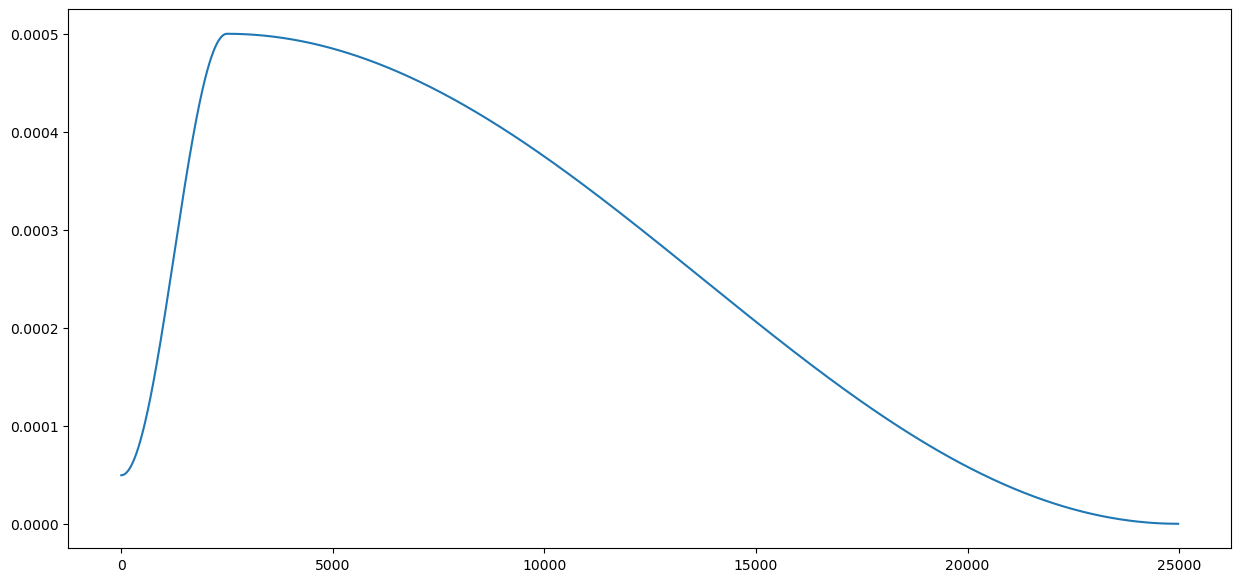

In [49]:
hparams = {
    "n_cnn_layers": 8,
    "n_rnn_layers": 4,
    "rnn_dim": 512,
    "n_class": len(unique_chars),
    "n_feats": 128,
    "stride": 2,
    "dropout": 0.1,
    "learning_rate": 5e-4,
    "batch_size": 16,
    "epochs": 2
}

train_audio_directory = './input/bengaliai-speech/train_mp3s/'
train_label_path = './working/norm_train.csv'
train_dataset, valid_dataset = torch.utils.data.random_split(BengaliAIDataset(train_label_path, train_audio_directory), 
                                                             [round(len(BengaliAIDataset(train_label_path, train_audio_directory))*0.999),
                                                              round(len(BengaliAIDataset(train_label_path, train_audio_directory))*0.001)])

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=16,
                          shuffle=True,  # Change to True for full training runs
                          collate_fn=lambda x: data_processing(x, 'training'))

model = SpeechRecognitionModel(
        hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
        hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
        )

optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'], 
                                          steps_per_epoch=int(len(train_loader)),
                                          epochs=hparams['epochs'],
                                          anneal_strategy='cos',
                                          div_factor=10,
                                          final_div_factor=100,
                                          pct_start=0.1)

lrs = []
steps = []
k=0
for j in range(hparams['epochs']):
    for i in range(len(train_loader)):
        lrs.append(scheduler.get_last_lr())
        scheduler.step()
        steps.append(k)
        k+=1
lrs = np.stack(lrs, axis=0)
steps = np.stack(steps)

plt.figure(figsize=(15,7))
plt.plot(steps, lrs)
# plt.yscale('log')
plt.show()
plt.close()

array([[5.00000000e-05],
       [5.01201474e-05],
       [5.02402948e-05],
       ...,
       [1.11416674e-06],
       [1.05708337e-06],
       [1.00000000e-06]])